In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from pandas import DataFrame
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import xgboost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from optuna import create_study
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import StackingClassifier

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [26]:
data = pd.read_csv('winequality-red.csv', sep = ';')

1.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [27]:
y = data.quality
X = data.drop(columns='quality')

learn_df, test_df, learn_y, test_y = train_test_split(X, y, test_size=0.3)

2.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [28]:
tree_classifier_model = DecisionTreeClassifier()
tree_classifier_model.fit(learn_df, learn_y)
tree_classifier_predict = tree_classifier_model.predict(test_df)
tree_accuracy = accuracy_score(test_y, tree_classifier_predict)
print('Accuracy for DecisionTreeClassifier: ', tree_accuracy)

Accuracy for DecisionTreeClassifier:  0.5791666666666667


In [29]:
bc_with_trees = BaggingClassifier(base_estimator=tree_classifier_model, n_estimators=100)
bc_with_trees.fit(learn_df, learn_y)
bc_with_trees_predict = bc_with_trees.predict(test_df)
bc_with_trees_accuracy = accuracy_score(test_y, bc_with_trees_predict)
print('Accuracy for BaggingClassifier with 100 trees: ', bc_with_trees_accuracy)

Accuracy for BaggingClassifier with 100 trees:  0.6666666666666666


In [30]:
def get_random_forest_accuracy_with_n_trees(trees_count:int):
    random_forest_model = RandomForestClassifier(n_estimators=trees_count)
    random_forest_model.fit(learn_df, learn_y)
    random_forest_predict = random_forest_model.predict(test_df)
    random_forest_accuracy = accuracy_score(test_y, random_forest_predict)
    return random_forest_accuracy

random_forest_accuracy = get_random_forest_accuracy_with_n_trees(100)

print('Accuracy for RandomForestClassifier with n_estimators=100: ', random_forest_accuracy)

Accuracy for RandomForestClassifier with n_estimators=100:  0.65625


Вывод: Bagging дает лучшие результаты, чем простое применение DecisionTreeClassifier,
RandomForestClassifier, использующий внутри тот же DecisionTreeClassifier дает сравнимые результаты. 
(были запуски в которых результат получался чуть лучше, текущий прогон - чуть ниже, но разница небольшая)

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [31]:
accuracy_by_n = DataFrame(columns=['n_trees', 'accuracy'])

for a in range(1,25):
    current_model = RandomForestClassifier(n_estimators=a*200)
    current_n = a*200
    current_accuracy = get_random_forest_accuracy_with_n_trees(current_n)
    row_df = DataFrame.from_dict({'n_trees': [current_n], 'accuracy': [current_accuracy]})
    accuracy_by_n = pd.concat([accuracy_by_n, row_df])
accuracy_by_n = accuracy_by_n.reset_index(drop=True)
accuracy_by_n = accuracy_by_n.set_index('n_trees')
accuracy_by_n.head()

/Users/max/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,accuracy
n_trees,
200,0.664583
400,0.670833
600,0.662500
800,0.660417
1000,0.668750


<AxesSubplot:xlabel='n_trees'>

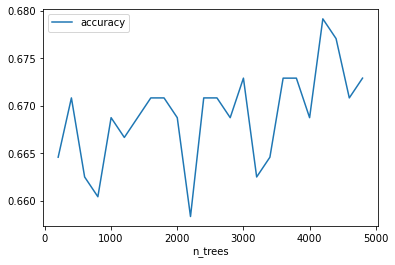

In [32]:
accuracy_by_n.plot()

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [33]:
sk_learn_gradient_boosting_model = GradientBoostingClassifier()
cross_val_score_sk_gradient_boosting = cross_val_score(sk_learn_gradient_boosting_model, learn_df, learn_y, scoring='accuracy')
print(f'Cross_val_score for gradient boosting sklearn: {cross_val_score_sk_gradient_boosting}')

print(f'xgboost library version {xgboost.__version__}')
xgboost_gradient_boosting_model = xgboost.XGBClassifier()

le = LabelEncoder()
learn_y_labeled = le.fit_transform(learn_y)
test_y_labeled = le.fit_transform(test_y)

cross_val_score_xgboost_gradient_boosting = cross_val_score(xgboost_gradient_boosting_model, learn_df, learn_y_labeled, scoring='accuracy', error_score='raise')
print(f'Cross_val_score for gradient boosting xgboost: {cross_val_score_xgboost_gradient_boosting}')

mean_sklearn = cross_val_score_sk_gradient_boosting.mean()
mean_xgboost = cross_val_score_xgboost_gradient_boosting.mean()

assert mean_xgboost > mean_sklearn

Cross_val_score for gradient boosting sklearn: [0.68303571 0.64732143 0.61607143 0.59821429 0.61434978]
xgboost library version 1.7.1
Cross_val_score for gradient boosting xgboost: [0.69196429 0.64285714 0.61160714 0.62053571 0.66367713]


Вывод: реализация градиентного бустинга с параметрами по умолчанию в xgboost дает лучшие результаты по метрике accuracy по сравнению с реализацией в sklearn

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [34]:
dict_param_grid = {'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
'n_estimators': [1, 10, 25, 50],
'max_depth': range(1,12)}

In [35]:
%%time 

grid_sklearn = GridSearchCV(sk_learn_gradient_boosting_model, cv=3, param_grid=dict_param_grid)

grid_sklearn.fit(learn_df, learn_y)
predicted  = grid_sklearn.predict(test_df)
accuracy = accuracy_score(test_y, predicted)
print(accuracy)
print(grid_sklearn.best_params_)


0.6541666666666667
{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 50}
CPU times: user 3min 51s, sys: 1.69 s, total: 3min 53s
Wall time: 3min 52s


In [36]:
%%time
grid_xgboost = GridSearchCV(xgboost_gradient_boosting_model, cv=3, param_grid=dict_param_grid)

grid_xgboost.fit(learn_df, learn_y_labeled)
predicted  = grid_xgboost.predict(test_df)

accuracy = accuracy_score(test_y_labeled, predicted)
print(accuracy)
print(grid_xgboost.best_params_)


0.625
{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50}
CPU times: user 5min 7s, sys: 2min 48s, total: 7min 56s
Wall time: 1min 19s


6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [37]:
l = LGBMClassifier()
l.fit(learn_df, learn_y)
pp = l.predict(test_df)
accuracy_lg = accuracy_score(test_y, pp)
print(f'Accuracy for lightgbm: {accuracy_lg}')

Accuracy for lightgbm: 0.6541666666666667


In [38]:
cat = CatBoostClassifier(silent=True)
cat.fit(learn_df, learn_y)
pp_cat = cat.predict(test_df)
accuracy_cat = accuracy_score(test_y, pp_cat)
print(f'Accuracy for catboost: {accuracy_cat}')

Accuracy for catboost: 0.6375


7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

In [39]:
grid_lgb = GridSearchCV(l, param_grid=dict_param_grid, cv=3)
grid_lgb.fit(learn_df, learn_y)
predicted = grid_lgb.predict(test_df)
accuracy_grid_lgb = accuracy_score(test_y, predicted)
print(f'Accuracy for grid with lightgbm: {accuracy_grid_lgb}')
print(grid_lgb.best_params_)

Accuracy for grid with lightgbm: 0.63125
{'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 50}


In [40]:
grid_cat = GridSearchCV(cat, param_grid = dict_param_grid, cv = 3)
grid_cat.fit(learn_df, learn_y)
predicted_cat = grid_cat.predict(test_df)
accuracy_grid_cat = accuracy_score(test_y, predicted_cat)
print(f'Accuracy for grid with catboost: {accuracy_grid_cat}')
print(grid_cat.best_params_)

Accuracy for grid with catboost: 0.6541666666666667
{'learning_rate': 0.5, 'max_depth': 11, 'n_estimators': 25}


8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [optuna](https://github.com/optuna/optuna) . Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [41]:
sampler = TPESampler(multivariate=False, seed=10)
study = create_study(direction="maximize", sampler=sampler)
def objective(
    trial,
    X,
    y,
    n_splits=3,
    n_repeats=2,
    n_jobs=1,
    early_stopping_rounds=50,
):
    param = {
        'silent':1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 6),
        'n_estimators': trial.suggest_int('n_estimators', 1, 6 ),
    }

    learn_df, test_df, learn_y, test_y = train_test_split(X, y, test_size=0.3)
    f = xgboost_gradient_boosting_model.fit(learn_df, learn_y)
    predicted = f.predict(test_df)
    acs =  accuracy_score(test_y, predicted)
    if acs > 0.75:
        print('Let count this result as pretty good to stop optimization')
        study.stop()
    return acs

In [42]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(
    lambda trial: objective(
        trial,
        X,
        LabelEncoder().fit_transform(y),
        n_jobs=8
    ),
    n_jobs=8,
)

# display params
hp = study.best_params

Let count this result as pretty good to stop optimization


In [43]:
good_learning_rate = hp['learning_rate']
good_max_depth = hp['max_depth']
good_n_estimators = hp['n_estimators']
print(f'Found with optuna: learning_rate: {good_learning_rate}, max_depth: {good_max_depth}, n_estimators: {good_n_estimators}')

Found with optuna: learning_rate: 0.06527352467731384, max_depth: 5, n_estimators: 5


9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [44]:
stacked_estimators = [('sk_learn_gradient_boosting', GradientBoostingClassifier()),
    ('xgboost',xgboost.XGBClassifier()), ('lightgbm', LGBMClassifier()), ('catboost', CatBoostClassifier())]

scf = StackingClassifier(estimators=stacked_estimators)
scf.fit(learn_df, learn_y)
predicted_by_stacking = scf.predict(test_df)

stacked_accuracy = accuracy_score(test_y, predicted_by_stacking)
print(f'Accuracy for stacking of 4 implementations of GradientBoosting: {stacked_accuracy}')

Learning rate set to 0.079582
0:	learn: 1.6900823	total: 2.53ms	remaining: 2.53s
1:	learn: 1.6095573	total: 4.05ms	remaining: 2.02s
2:	learn: 1.5328758	total: 5.78ms	remaining: 1.92s
3:	learn: 1.4686850	total: 7.54ms	remaining: 1.88s
4:	learn: 1.4120408	total: 9.13ms	remaining: 1.82s
5:	learn: 1.3615289	total: 10.8ms	remaining: 1.78s
6:	learn: 1.3184916	total: 13.4ms	remaining: 1.9s
7:	learn: 1.2798687	total: 15.5ms	remaining: 1.93s
8:	learn: 1.2453839	total: 17.6ms	remaining: 1.94s
9:	learn: 1.2137958	total: 19.5ms	remaining: 1.93s
10:	learn: 1.1853164	total: 21.1ms	remaining: 1.9s
11:	learn: 1.1580085	total: 22.8ms	remaining: 1.88s
12:	learn: 1.1377926	total: 24.6ms	remaining: 1.87s
13:	learn: 1.1146490	total: 26.2ms	remaining: 1.84s
14:	learn: 1.0942696	total: 28ms	remaining: 1.84s
15:	learn: 1.0765848	total: 30.3ms	remaining: 1.86s
16:	learn: 1.0615659	total: 32.4ms	remaining: 1.87s
17:	learn: 1.0454781	total: 34.1ms	remaining: 1.86s
18:	learn: 1.0306137	total: 35.7ms	remaining: 1.

Результаты весьма скромные, по сравнению с тем, что получилось с помощью optuna

10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [45]:
stacked_estimators = [('sk_learn_gradient_boosting', GradientBoostingClassifier(learning_rate=good_learning_rate, max_depth=good_max_depth,
n_estimators=good_n_estimators)),
    ('xgboost',xgboost.XGBClassifier(learning_rate=good_learning_rate, max_depth=good_max_depth,
n_estimators=good_n_estimators)), ('lightgbm', LGBMClassifier(learning_rate=good_learning_rate, max_depth=good_max_depth,
n_estimators=good_n_estimators)), ('catboost', CatBoostClassifier(learning_rate=good_learning_rate, max_depth=good_max_depth,
n_estimators=good_n_estimators))]

scf = StackingClassifier(estimators=stacked_estimators)
scf.fit(learn_df, learn_y)
predicted_by_stacking = scf.predict(test_df)

stacked_accuracy = accuracy_score(test_y, predicted_by_stacking)
print(f'Accuracy for stacking of 4 implementations of GradientBoosting with Optuned parameters: {stacked_accuracy}')

0:	learn: 1.7031126	total: 1.17ms	remaining: 4.69ms
1:	learn: 1.6321242	total: 2.78ms	remaining: 4.17ms
2:	learn: 1.5666909	total: 3.94ms	remaining: 2.63ms
3:	learn: 1.5092470	total: 5.12ms	remaining: 1.28ms
4:	learn: 1.4582120	total: 6.27ms	remaining: 0us
0:	learn: 1.7049500	total: 1.21ms	remaining: 4.84ms
1:	learn: 1.6321728	total: 2.32ms	remaining: 3.48ms
2:	learn: 1.5693220	total: 3.31ms	remaining: 2.21ms
3:	learn: 1.5154768	total: 4.34ms	remaining: 1.09ms
4:	learn: 1.4653249	total: 5.41ms	remaining: 0us
0:	learn: 1.7046794	total: 823us	remaining: 3.29ms
1:	learn: 1.6334011	total: 1.67ms	remaining: 2.5ms
2:	learn: 1.5673344	total: 2.71ms	remaining: 1.81ms
3:	learn: 1.5116422	total: 3.68ms	remaining: 919us
4:	learn: 1.4600810	total: 4.77ms	remaining: 0us
0:	learn: 1.7053912	total: 1.06ms	remaining: 4.25ms
1:	learn: 1.6371882	total: 2.09ms	remaining: 3.14ms
2:	learn: 1.5721629	total: 3.1ms	remaining: 2.07ms
3:	learn: 1.5164287	total: 4.11ms	remaining: 1.03ms
4:	learn: 1.4626319	total

Взял лучшие параметры, подобранные с помощью optuna, применил ко всем реализациям алгоритма и получил результаты ещё хуже,
чем стэкинг реализаций с параметрами по умолчанию